## Zero noise extrapolation with mitiq on Amazon Braket

In this notebook, we look at extrapolative approaches for mitigating errors, namely Zero-Noise Extrapolation (ZNE) and a variant, Layerwise-Richardson Extrapolation, using [mitiq](https://mitiq.readthedocs.io/en/stable/) with Amazon Braket. Here, mitiq provides built in functions to (1) execute circuits with ZNE, (2) prepare the extrapolated circuits, and (3) recombine and post-process results.

ZNE provides the backbone mitigation strategy for numerous succussful quantum simulations, and has been incorporated into techniques such as [probabilistic phase amplification](https://arxiv.org/pdf/2108.09197). Numerous references can be found on the [mitiq page](https://mitiq.readthedocs.io/en/stable/guide/zne.html). 

### Installing mitiq
>[!WARNING]
>mitiq is distributed under the GPL GNU v3 license, and so is not included by default with `amazon-braket-examples` requirements or in the Amazon Braket Notebook Instances. To install, uncomment the first line in the next code block, and restart the notebook. 

Mitiq utilizes Cirq as the backend, and may represent circuits using their representation. 

In [1]:
# !pip install -U mitiq
try:
    import mitiq  # noqa: F401
    print("Package 'mitiq' is installed.")
except ImportError:
    print("!! Package 'mitiq' is not installed !!")

Package 'mitiq' is installed.



### Basics of Zero Noise Extrapolation

Given a function $f(x)$, we would like to estimate $f(0)$ using a series of varying $x > 0$. For ZNE, $x$ describes the noise parameter. Importantly, making specific assumptions about noise sources and behavior within our circuit, differing values of $x$ correspond with different circuits where we have amplified noise. The most common strategy for noise amplification is unitary gate folding, where we take a gate $U$, and map it to the logically equivalent $U U^\dagger U$. This can be the global unitary $U$ (global folding), or local unitaries composed together ($U_i$). Thus, independent noise sources within our system can be amplified by a n odd factor. However, some noise, particularly coherent noise, will remain constant. Correlated noise also can have strange behaviors. 

Different extrapolation schemes lead to different biases, and so generally we do not consider ZNE to be an unbiased approach for all noise models. More details can be found on mitiq`s [Theory of ZNE](https://mitiq.readthedocs.io/en/stable/guide/zne-5-theory.html) page.

![Extrapolation of a simple expectation value.](extrapolation.png)


### Setting up our problem

In order to set up our ZNE problem, we first import relevant libraries, and construct our system of interest. 

In [2]:
import json
import warnings

import matplotlib.pyplot as plt
import numpy as np
from mitiq.zne import construct_circuits
from mitiq_braket_tools import braket_measurement_executor
from qiskit_braket_provider import to_braket, to_qiskit

from braket.circuits import Circuit
from braket.circuits.observables import Z
from braket.devices import LocalSimulator
from braket.emulation.local_emulator import LocalEmulator

np.set_printoptions(linewidth=400,precision=3,suppress=True)
warnings.filterwarnings("ignore", category=UserWarning, module="qiskit_braket_provider")

# here we will use the noise from a device emulator 

with open("emerald_properties_251106.json","r") as fp:
    props = json.load(fp)

emulator = LocalEmulator.from_json(props)
qd = LocalSimulator("braket_dm",noise_model= emulator._noise_model)
num_shots = 10000
num_qubits = 8

## UNCOMMENT_TO_RUN
# num_qubits = 2

qubit_labels = [3,9,17,25,33,41,47,48,52][:num_qubits]



In [3]:
def rzz_angle(i,j, theta):
    """ implement e^(i  theta Z_i Z_j) """
    return Circuit().cnot(i,j).rz(j, -2 *theta).cnot(i,j)

def ising_1d(self_interaction : float, hopping : float, num_qubits : int) -> Circuit:
    circ = Circuit()
    for i in range(num_qubits):
        circ.rx(i,-2*self_interaction)
    for i in range(0,num_qubits-1,2):
        circ+= rzz_angle(i,i+1, hopping)
    for i in range(1,num_qubits-1,2):
        circ+= rzz_angle(i,i+1, hopping)
    return circ

In [4]:
time_step = ising_1d(0.2,0.05, num_qubits)


Here we see a standard 1-d transverse field Ising model circuit, realized using ZZ Pauli Gadgets. Now we can get ideal expectation values and visualize them. 

In [5]:
print('Calculating ideal evolutions...')
qd_exact = LocalSimulator()
obs = Circuit()

for i in range(num_qubits):
    obs.expectation(Z(i))

circ = Circuit()
ideal_evs = []
ideal_stds = []
for steps in range(10):
    circ+= time_step + time_step
    res = qd_exact.run(circ + obs, shots = 0).result()
    ideal_evs.append(res.values)

dat = np.array(ideal_evs)


Calculating ideal evolutions...


Text(0, 0.5, 'Local Z_i Populations')

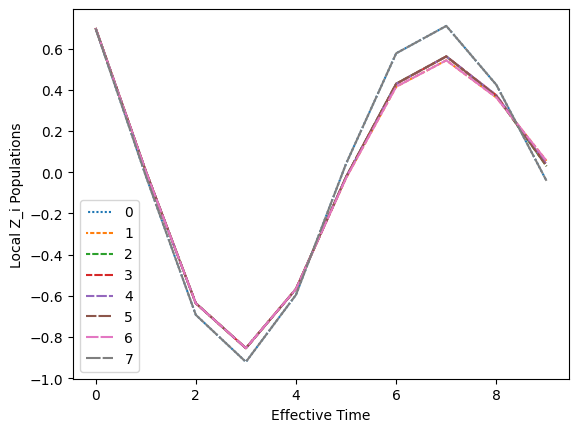

In [6]:
# plt.errorbar(range(len(ideal_evs)), ideal_evs, ideal_stds, capsize=3, marker='x',linewidth=1)
for i in range(num_qubits):
    plt.plot(range(10), dat[:,i], label = f'{i}', linestyle = (1,(i+1,1)))
plt.legend()
plt.xlabel("Effective Time")
plt.ylabel("Local Z_i Populations")

In this regime we see oscillatory behavior that is pretty consistent across local sites, with the exception of the edges.  

Below, we calculate the same result using our noise model (note we are not quite using ProgramSets yet). 

In [7]:
print('Calculating noisy results...')
obs = Circuit()
for i in qubit_labels:
    obs.expectation(Z(i))

noisy_circ = Circuit()
noisy_evs = []
for step in range(10):
    noisy_circ+= time_step + time_step
    ncirc = to_braket(
        to_qiskit(
            noisy_circ, add_measurements=False), 
            basis_gates=["cz","r"],  # noise model is designed for CZ and r gates
            optimization_level=2, qubit_labels=qubit_labels)
    print(f'Running step: {step}')
    res = qd.run(ncirc + obs, shots = num_shots).result()
    noisy_evs.append(res.values)
print('Done!')
noisy_evs = np.array(noisy_evs)

Calculating noisy results...
Running step: 0
Running step: 1
Running step: 2
Running step: 3
Running step: 4
Running step: 5
Running step: 6
Running step: 7
Running step: 8
Running step: 9
Done!


Text(0, 0.5, 'Expectation Value')

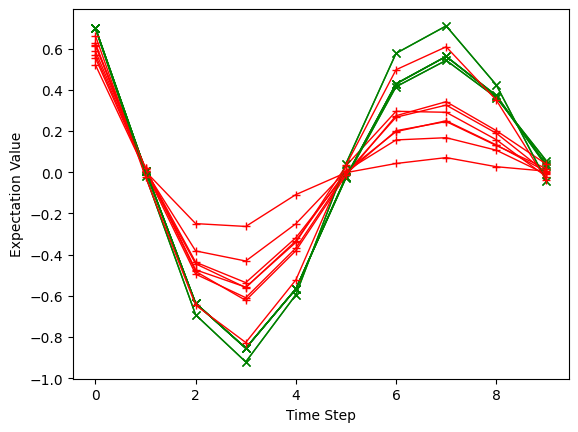

In [8]:
for i in range(num_qubits):
    plt.plot(range(10), dat[:,i], marker='x',linewidth=1, c = 'g',
                label=f"ideal: <Z({i})>"
                )
    plt.plot(range(0,len(noisy_evs)), noisy_evs[:,i], marker='+',c='r',linewidth=1,
                label=f"noisy: <Z({i})>")
plt.xlabel("Time Step")
plt.ylabel("Expectation Value")

### Running the Noise-Extrapolated Results

Finally, to compare, we will run our ZNE procedure. Note, here the `scale_factors` represent the noise amplification levels we will perform. We will use the default strategy but `mitiq` allows you to explore various [folding options](https://mitiq.readthedocs.io/en/stable/guide/zne-3-options.html) for integer and non-integer powers. 

Additionally, to look at the extrapolations, we will use the `construct_circuits` + `combine_results` pattern, as opposed to the 1-shot Executor based approach seen in the first notebook. We can still use an Executor, as we just need an expectation value, but we will not automate the entire process. 

In [9]:
scale_factors = [1.0, 2.0, 3.0]


obs = Circuit()
for i in qubit_labels:
    obs.expectation(Z(i))

circ=  Circuit()
zne_evs = np.zeros((10,3,num_qubits))
for step in range(10):
    circ+= time_step + time_step
    circuits = construct_circuits(circ, scale_factors)
    print(f'Running step: {step}')
    for j,item in enumerate(circuits):
        print(f'  - subcircuit {j}')
        ncirc = to_braket(
            to_qiskit(
                item, add_measurements=False), 
                basis_gates=["cz","r"], 
                optimization_level=0, qubit_labels=qubit_labels)

        res = qd.run(ncirc + obs, shots = num_shots).result()
        zne_evs[step,j,:] = res.values
print('Done!')

Running step: 0
  - subcircuit 0
  - subcircuit 1
  - subcircuit 2
Running step: 1
  - subcircuit 0
  - subcircuit 1
  - subcircuit 2
Running step: 2
  - subcircuit 0
  - subcircuit 1
  - subcircuit 2
Running step: 3
  - subcircuit 0
  - subcircuit 1
  - subcircuit 2
Running step: 4
  - subcircuit 0
  - subcircuit 1
  - subcircuit 2
Running step: 5
  - subcircuit 0
  - subcircuit 1
  - subcircuit 2
Running step: 6
  - subcircuit 0
  - subcircuit 1
  - subcircuit 2
Running step: 7
  - subcircuit 0
  - subcircuit 1
  - subcircuit 2
Running step: 8
  - subcircuit 0
  - subcircuit 1
  - subcircuit 2
Running step: 9
  - subcircuit 0
  - subcircuit 1
  - subcircuit 2
Done!


### Performing Extrapolations with mitiq.zne.inference Factories


Now that we have three results, we will look at means of extrapolating these via post processing. In particular, we consider three different fits, a `LinearFactory`, an `ExponentialFactory` and a `RichardsonFactory`. 

The `LinearFactory` performs a simple least-squared fit of the data. 

The `ExpFactory` tries to fit an exponential curve to the data of the form $y(x) = a + b * \exp(-c * x)$, with $c > 0$. Notably, we can also incorporate the infinite limit, which effectively sets $a$, and then allows for a linear regression of the form $log(y(x)) = log(b) - c x$. For common expectation value problems, this is typically the trace of the observable $a = {\rm Tr}[\hat O]$. 

The `RichardsonFactory` performs Richardson extrapolation to fit $n$ data points to a degree $n-1$ polynomial, of which there is a unique solution. Thus it has some nice guarantees, namely there are existing expression for the variance and bias of the resulting estimate we can harness. 


In [10]:
from mitiq.zne import combine_results
from mitiq.zne.inference import ExpFactory, LinearFactory, RichardsonFactory

extrapolated_linear = np.zeros((10,num_qubits))
extrapolated_richard = np.zeros((10,num_qubits))
extrapolated_exp = np.zeros((10,num_qubits))

for i in range(10):
    for j in range(num_qubits):
        extrapolated_exp[i,j] = ExpFactory.extrapolate(scale_factors, zne_evs[i,:,j].tolist(), asymptote = 0.0, eps = 0.01)
        extrapolated_richard[i,j] = combine_results(scale_factors, zne_evs[i,:,j].tolist(), RichardsonFactory.extrapolate)
        extrapolated_linear[i,j] = combine_results(scale_factors, zne_evs[i,:,j].tolist(),  LinearFactory.extrapolate)



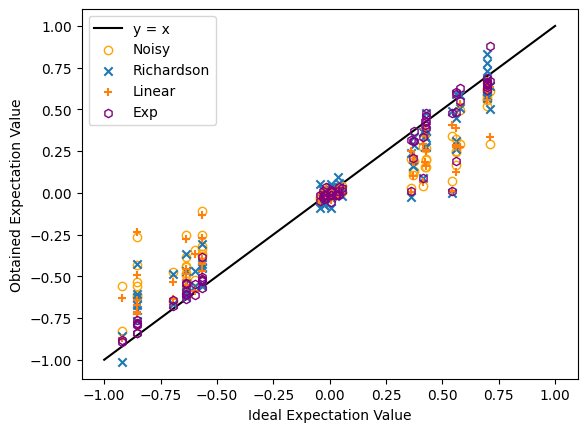

In [11]:
xs = np.linspace(-1,+1,51)
plt.plot(xs,xs,color='k',zorder=0, label="y = x")

plt.scatter(dat.flatten(), noisy_evs.flatten(), marker = 'o', facecolor=(0,0,0,0), edgecolor='orange', label="Noisy")
plt.scatter(dat.flatten(), extrapolated_richard.flatten(), label="Richardson", marker = 'x')
plt.scatter(dat.flatten(), extrapolated_linear.flatten(), label="Linear", marker = '+')
plt.scatter(dat.flatten(), extrapolated_exp.flatten(), label="Exp", marker = 'h', facecolor=(0,0,0,0), edgecolor='purple')
plt.xlabel("Ideal Expectation Value")
plt.ylabel("Obtained Expectation Value")
plt.legend()

In [12]:
for data, name in zip([extrapolated_linear, extrapolated_richard, extrapolated_exp], ["Linear ", "Richard", "Exponen"]):
    score = np.square(dat.flatten() - data.flatten())
    print(f'Average residual error [{name}]: {np.average(score):.4f}({np.std(score):.4f})')

Average residual error [Linear ]: 0.0376(0.0653)
Average residual error [Richard]: 0.0218(0.0447)
Average residual error [Exponen]: 0.0110(0.0386)


Taking a closer look at the exponential function performance, we can model it as:

Text(0, 0.5, 'Expectation Value')

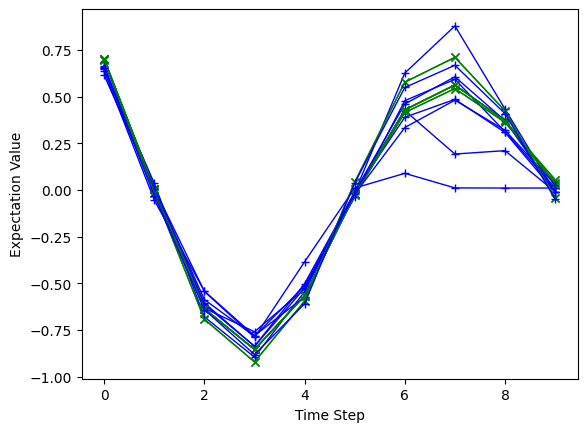

In [13]:
for i in range(num_qubits):
    plt.plot(range(10), dat[:,i], marker='x',linewidth=1, c = 'g',
                label=f"ideal: <Z({i})>"
                )
    plt.plot(range(0,len(noisy_evs)), extrapolated_exp[:,i], marker='+',c='b',linewidth=1,
                label=f"noisy: <Z({i})>")
plt.xlabel("Time Step")
plt.ylabel("Expectation Value")

We can further visualize our fits:

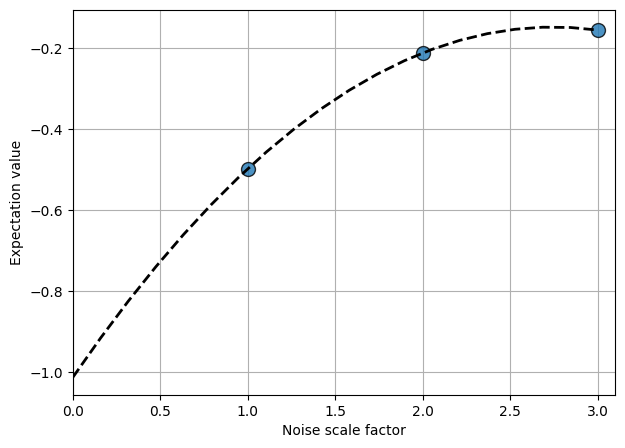

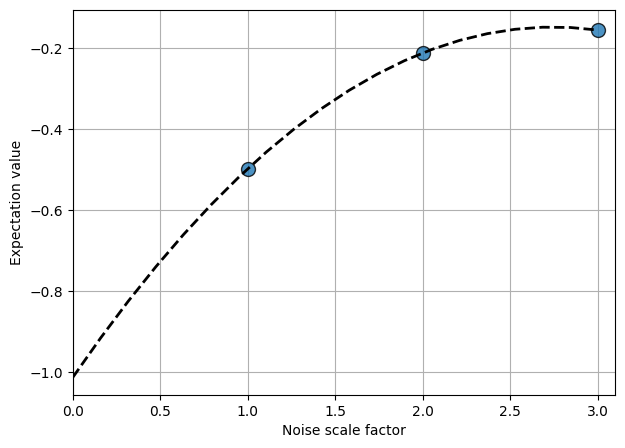

In [14]:
factory =  RichardsonFactory(scale_factors)
for s,e in zip(scale_factors, zne_evs[3,:,0]):
    factory.push({"scale_factor":s}, e)
factory.reduce()

factory.plot_fit()

### On Bias and Variance in ZNE

For ZNE, there are further factors which can impact the quality of our extrapolation, and lead to increased or modified variances as well as non-zero biases. Below we discuss the three methods covered above. 

#### Variance in Linear Extrapolation 

A linear fit uses a Ordinary Least Squares estimator, which based on a series of points $(x_k, y_k)$, with variances $\sigma_k$, produces a linear fit with parameters $\hat \beta_0$ and $\hat \beta_1$. In particular we are interested in the estimator $\hat \beta_0$, as this represents the varince of our estimator. From points with similar standard deviations, this can be written as:

$ {\rm Var}[\beta_0] = \sigma^2 (\frac{1}{N_{points}} + \frac{\bar x^2}{\sum_i (x_i - \bar x )^2}) $


In [15]:
xs = np.array(scale_factors)
x_bar = np.average(xs)
x_del = xs - x_bar

var_beta_0 = 1/num_shots * (1/len(scale_factors) + x_bar**2 / np.dot(x_del, x_del))

print(f"Variance and standard deviation of our estimate: {var_beta_0:.8f}, {np.sqrt(var_beta_0):.4f}")

Variance and standard deviation of our estimate: 0.00023333, 0.0153


We can also compare this with the extrapolated result from mitiq: 

In [16]:
from mitiq.zne.inference import mitiq_polyfit

test = mitiq_polyfit(scale_factors, zne_evs[3, :, 0], deg=1,weights= [100,100,100])
cov = test[1]
print('Calculated from mitiq: ',np.sqrt(np.diag(cov))[1])
res = LinearFactory.extrapolate(scale_factors, zne_evs[3,:,0],full_output=True)


Calculated from mitiq:  0.14330547791344164


Which is precisely what we would expect. The ordinary least squares approach is unbiased in the sense that the regression model is unbiased, however if the generating function is not linear with normally distributed error variables, then there will be resulting bias. Generally we expect that this can be proportion to the noise strength, and if our scale factors exist in a linear region, then the linear approach might be suitable. It is also appropriate for equal-variance data, i.e. each point is taken with the same number of shots. 

#### Variance in Exponential Extrapolation

Generally, exponential fits can be more tricky. There are several of fitting exponentials and higher order polynomials in mitiq, which can be found in the [inference file](https://github.com/unitaryfoundation/mitiq/blob/main/mitiq/zne/inference.py) and [documentation](https://mitiq.readthedocs.io/en/stable/guide/zne-3-options.html). We focus on one variation, which has a nice correlation with the linear fit. Broadly, mitiq models an exponential function as:

$ f(x) = a + b * \exp(-c * x)$

where $a$ can be specified as the asymptote, which for traceless observables is 0. If we also use the default `avoid_log=False`, we can treat this as a function in log space. I.e., we can write this as:

$f(x) = b * \exp(-c * x)$

Taking the log of this yields:

$\log f(x) = y(x) = \log b - c x $.

We can thus identify $\log b$ with $\beta_0$ and $- c$ with $\beta_1$ above. Noting that the variance of our estimate:

${\rm Var}[f(0)] = {\rm Var}[e^{\beta_0}]$

this will correspond with a log-normal distribution, assuming that $\beta_0$ is normally distributed. Generally, one problem is that our variances are no longer homoscedastic (i.e. equal variance). Thus we go from using standard linear least squares regression to a weighted least squares regression. In mitiq, a weight least square regression is used with $w_i = \sqrt{|y_i|}$. This can also be supplied as $|y_i|$ based on the normalization, but in practice the square root may be more stable. From that, we can calcualte the weighted-least-squares variance, and compare with the `mitiq_polyfit` function.  

In [17]:
def wls_variance(X, y, weights):
    x = np.zeros((2,len(weights)))
    x[0,:] = np.ones_like(weights)
    x[1,:] = X
    x = x.T
    W = np.diag(weights)
    mat = x.T @ W @ x
    return np.linalg.pinv(mat)

cov = wls_variance(xs, np.log(zne_evs[3, :, 0]),weights = num_shots*np.abs(zne_evs[3, :, 0]))
estimate = ExpFactory.extrapolate(scale_factors, zne_evs[3,:,0], asymptote=0, eps = 0.01)

sigma = np.abs(estimate) * np.sqrt(cov[1,1])

print(f'Standard deviation for exponential estimate: {sigma}')


Standard deviation for exponential estimate: 0.012476644521987792


/var/folders/1_/bfh8x9qn75164y0b808mvhrh0000gq/T/ipykernel_84910/60025335.py:10: RuntimeWarning: invalid value encountered in log
  cov = wls_variance(xs, np.log(zne_evs[3, :, 0]),weights = num_shots*np.abs(zne_evs[3, :, 0]))


>[!Note]
> To properly normalize the exponential distribution in the log-space, one should have heteroscedastic data in normal space and homoscedastic dat in log space, i.e. performing some sort of shot allocation. Unfortuantely, the proper alllocation here is hard to know apriori - one proxy might simply be the number of two qubit gates and infidelity. If this is in a linear region, i.e. $\langle O \rangle \approx \langle O \rangle e^{-IF * N_{gates}} \approx \langle O \rangle (1 - IF * N_{gates})$, then the variances will be transformed appropriately. To properly evaluate this in mitiq, we can supply our own weights to mitiq_polyfit, and output the relevant extrapolation data.  

#### Variance in Richardson Extrapolation

Finally, Richardson extrapolation has the advantage of having exact formulae for the bias and variance of the extrapolation (see [Krebsbach et al.](https://arxiv.org/abs/2201.08080) for an excellent overview of Richardson extrapolation for QEM). Specifically, based on the Lagrange coefficients, we can estimate our variance. In contrast with linear and exponential extrapolation techniques, Richardson extrapolation also can produce a rigorous bound on the bias. Additionally, Richardson extrapolation gives more insights into noise spacing and allows for flexibility on shot allocation. 

For $x=0$, the Lagrange polynomial of a $k-$degree function can be written as:

$ \gamma_j = \prod_{k \neq j} \frac{x_k}{x_j - x_k} $ 

These have a nodal structure, i.e. at each point only $x_k$ will be non-zero, and we can express the extrapolation as 

$R_n = \sum_j f(x_j) \gamma_j $ 

The bias can be expressed from the theory of polynomial functions, and potentially estimated using known information or approximation information on the function. As mentioned in [previous work](https://arxiv.org/abs/2201.08080), to obtain a truly bias-free Richardons extrapolation requires an exponential number of points and thus shots, but in practice we can bound error below reasonable rates quite well. 

Regardless, the variance has the formula

$ {\rm Var} [\hat R_n] = \sum_{j=0}^n \gamma_j^2 \frac{\sigma^2}{N_j} $ 

Here we see that the variance primarily depends on $\gamma_j$, with an ideal allocation being 

$N_j = M \frac{|\gamma_j|}{\Gamma} $ 

In [18]:
gamma = []
for j,xj in enumerate(scale_factors):
    temp = 1
    for k,xk in enumerate(scale_factors):
        if k!=j:
            temp*= xk/(xj-xk)
    gamma.append(temp)

print(f'Coefficients: {gamma}')
Gamma = np.sum(np.abs(gamma))
print(f'Total l1 norm: {Gamma}')

var = sum([g**2 / num_shots for g in gamma])

print(f'Expected variance and sigma: {var}, {np.sqrt(var)}')

Coefficients: [3.0, -3.0, 1.0]
Total l1 norm: 7.0
Expected variance and sigma: 0.0019, 0.04358898943540673


### Layerwise Richardson Extrapolation and Variants

For realistic systems, there can be much more complex noise models which affect noise sources. We can address this in a number of ways, particularly by how we change the relation between our extrapolation and circuit. 

One such approach supported in mitiq is [layerwise Richarson extrapolation (LRE)](https://mitiq.readthedocs.io/en/stable/guide/lre.html). If we consider our original extrpaolating function $f(x)$ with a multivariate input, i.e. $f(x_0, x_1, x_2,...)$, then we can still perform many types of regression. While this is still an open research area, LRE provides an extensive way to perform this extrapolation. 

In [19]:
from mitiq.lre.multivariate_scaling import multivariate_layer_scaling

degree = 2
fold_multiplier = 1
num_chunks = 2

test_circ =  Circuit()
test = ising_1d(0.2,0.05, num_qubits)

for step in range(8*2):
    test_circ += test
test_circ = to_braket(
    to_qiskit(
        test_circ, add_measurements=False), 
        basis_gates=["cz","rx","rz"], 
        optimization_level=0)


lre_circuits = multivariate_layer_scaling(test_circ, degree, fold_multiplier, num_chunks = num_chunks)

print(f'total number of generated circuits: {len(lre_circuits)}')



total number of generated circuits: 6


Importantly we use the `num_chunks` argument to reduce the number of partitions within the circuit, and thus the overall degree of the polynomial. 

In [20]:
from mitiq import Observable, PauliString
from mitiq.lre.inference import multivariate_richardson_coefficients

executor = braket_measurement_executor(qd,10000, verbatim=False, batch_if_possible=False)
ideal_executor = braket_measurement_executor(LocalSimulator(), 10000, verbatim = False, batch_if_possible= False)

results = [executor.evaluate(
    circuits=c, 
    observable=Observable(PauliString("Z" + "I"*(num_qubits-1)))) for c in lre_circuits]

ideal = ideal_executor.evaluate(
    circuits=test_circ, 
    observable=Observable(PauliString("Z" + "I"*(num_qubits-1))))

print(results)

coefficients = multivariate_richardson_coefficients(
    test_circ,
    fold_multiplier=fold_multiplier,
    degree=degree,
    num_chunks=num_chunks)
print(coefficients)

/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/mitiq/interface/mitiq_braket/conversions.py:116: UserWarning: Measurement gate removed when converting from Cirq to Braket.
  warn("Measurement gate removed when converting from Cirq to Braket.")
/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/mitiq/interface/mitiq_braket/conversions.py:116: UserWarning: Measurement gate removed when converting from Cirq to Braket.
  warn("Measurement gate removed when converting from Cirq to Braket.")
/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/mitiq/interface/mitiq_braket/conversions.py:116: UserWarning: Measurement gate removed when converting from Cirq to Braket.
  warn("Measurement gate removed when converting from Cirq to Braket.")
/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/mitiq/interface/mitiq_braket/conversions.py:116: UserWarning: Measurement gate removed when converting from 

[[(0.6764+0j)], [(0.6426+0j)], [(0.6438+0j)], [(0.5998+0j)], [(0.5946+0j)], [(0.6008+0j)]]
[3.000000000000001, -1.5000000000000002, -1.5000000000000002, 0.375, 0.24999999999999994, 0.375]


In [21]:
from mitiq.lre.lre import combine_results

lre_result = combine_results(
    np.reshape(results,(len(results),)), circuit=test_circ, degree=degree, fold_multiplier=fold_multiplier, num_chunks = num_chunks)
print(f'Layerwise Richardson Extrapolation result: {lre_result}')
print(f"Ideal: {ideal[0]}")
print(results)
noisy = abs(results[0][0] - ideal[0])
imp_fact = noisy / abs(lre_result - ideal[0])
if imp_fact < 1:
    print("Extrapolation decreased result, might be an issue in your extrapolation or noise model.")
print(f"Improvement over noisy: {imp_fact:.1f}x")


Layerwise Richardson Extrapolation result: (0.6984750000000004+0j)
Ideal: (0.7196+0j)
[[(0.6764+0j)], [(0.6426+0j)], [(0.6438+0j)], [(0.5998+0j)], [(0.5946+0j)], [(0.6008+0j)]]
Improvement over noisy: 2.0x


### Conclusion

In this notebook we looked at extrapolation based approaches, including standard zero-noise extrapolation (ZNE)as well as layerwise Richardson extrapolation (LRE). mitiq has many other options for enhancing ZNE results, which we encourage the interested use to explore. We will epxlore larger scale applications in subseqeuent notebooks. 

### References

1. Unitary Foundation, [**Mitiq Guide, ZNE**](https://mitiq.readthedocs.io/en/stable/guide/zne.html), Accesesd 12/9/2025. 
1. Temme et al., [**Error Mitigation for Short-Depth Quantum Circuits**](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.119.180509) (2017), Phy. Rev. Lett., 119, 180509. 
2. Majumdar et al., [**Best practices with ZNE**](https://arxiv.org/abs/2307.05203) (2023) arXiv:2307.05203. 
3. Russo, Mari, [**Quantum error mitigation by layerwise Richardson extrapolation**](https://arxiv.org/abs/2402.04000) (2024). Phys. Rev. A, 110, 062420. 
4. Krebsbach et al., [**Optimization of Richardson extrapolation for quantum error mitigation**](https://arxiv.org/abs/2201.08080) (2022) Phys. Rev. A, 106, 062436. 